# Check-worthiness detection using Large Language Models

First, the necessary python modules are imported

In [2]:
%load_ext autoreload

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline
from claimbuster_utils import load_claimbuster_dataset
from tqdm.auto import tqdm
import json
import numpy as np
import re
import torch
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd

/cluster/home/matssbra/.conda/envs/fakeNews/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-01 14:32:31.042524: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 14:32:31.042598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 14:32:31.044470: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 14:32:31.055687: I tensorflow/core/platform/cpu_feature_guard.cc:182] This T

## Load model and dataset

In [16]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2",
    torch_dtype=torch.float16,
    quantization_config = bnb_config,
    # attn_implementation="flash_attention_2", 
    device_map={"": 0}
)
model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
pipe = pipeline(
    "text-generation", 
    model=model, 
    tokenizer=tokenizer, 
    return_full_text=False,
    max_new_tokens=256,
    pad_token_id=tokenizer.eos_token_id
)


Loading checkpoint shards: 100%|██████████| 3/3 [00:48<00:00, 16.08s/it]


## Zero-shot classification

In [15]:
with open("../prompts/ClaimBuster/standard/zero-shot.txt", "r") as f:
    instruction = f.read()
use_contextual = False
data = load_claimbuster_dataset(
    "../data/ClaimBuster_Datasets/datasets",
    use_contextual_features=use_contextual,
    debate_transcripts_folder="../data/ClaimBuster_Datasets/debate_transcripts",
)

texts = data["Text"]
if use_contextual is False:
    prompts = [f"{instruction} '''{text}'''" for text in texts]
    zeroshot_output = "../results/ClaimBuster/zeroshot1.csv"
else:
    contexts = data["previous_sentences"].tolist()
    prompts = [
        f"{instruction} For context, the following senteces were said prior to the one in question: {context} Only evaluate the check-worthiness of the following sentence: '''{text}'''"
        for text, context in zip(texts, contexts)
    ]
    zeroshot_output = "../results/ClaimBuster/zeroshot_contextual.csv"


class ProgressDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __len__(self):
        return len(self.dataset)


prompts_data = ProgressDataset(prompts)

dataset_with_scores = data.copy()

display(data.head())
dict_matcher = re.compile(r"{.*}")
score_matcher = re.compile(r"([Ss]core[^\d]*)(\d+)")
non_check_worthy_matcher = re.compile(
    r"(non-checkworthy)|(not check-worthy)|(non check-worthy)"
)

responses = pipe(prompts_data, batch_size=128)
for index, result in enumerate(tqdm(responses, total=len(prompts))):
    response = result[0]["generated_text"].replace("\n", "")
    dataset_index = data.index[index]
    try:
        parsed_json = json.loads(dict_matcher.search(response).group(0))
        dataset_with_scores.loc[dataset_index, "score"] = parsed_json["score"]
        dataset_with_scores.loc[dataset_index, "reasoning"] = parsed_json["reasoning"]
    except (json.decoder.JSONDecodeError, AttributeError) as e:
        # Try to find score
        score = score_matcher.search(response)
        if score is not None:
            score = score[2]
        else:
            score = 0.0 if non_check_worthy_matcher.search(response) else np.nan
        dataset_with_scores.loc[dataset_index, "score"] = score
        dataset_with_scores.loc[dataset_index, "reasoning"] = response
        continue
# Set the following column order: Verdict, score, Text, reasoning, previous_sentences
columns =  ["Verdict", "score", "Text", "reasoning"]
if use_contextual:
    columns.append("previous_sentences")
dataset_with_scores = dataset_with_scores[columns]
dataset_with_scores.to_csv(zeroshot_output, index=True)

,Verdict,Text
sentence_id,,
27247,1,We're 9 million jobs short of that.
10766,1,"You know, last year up to this time, we've los..."
3327,1,And in November of 1975 I was the first presid...
19700,1,And what we've done during the Bush administra...
12600,1,Do you know we don't have a single program spo...


/cluster/home/matssbra/.conda/envs/fakeNews/lib/python3.11/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  0%|          | 0/9674 [00:00<?, ?it/s]

  0%|          | 0/9674 [00:03<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.20 GiB. GPU 0 has a total capacity of 31.74 GiB of which 1.10 GiB is free. Including non-PyTorch memory, this process has 30.64 GiB memory in use. Of the allocated memory 27.73 GiB is allocated by PyTorch, and 2.54 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Discussion of results

             Verdict                                               Text  \
sentence_id                                                               
25315              1  Georgie Anne, we, believe me, supported the Si...   
33747              1           I have fought against that as a senator.   
15380              1  Six predecessors of mine who served in the Ova...   
5730               1  Even FOX News disputes it, and that doesn't ha...   
33361              1  He choked and then got into a Twitter war beca...   
...              ...                                                ...   
8204               0  But let's not put it there; let's put it in te...   
32104              0                        Oh, you didn't delete them?   
25400              0  We have more at stake in space satellites than...   
33659              0  Well, let me translate that, if I can, Chris, ...   
19323              0  Now, if these aren't special interests, I've g...   

             score      

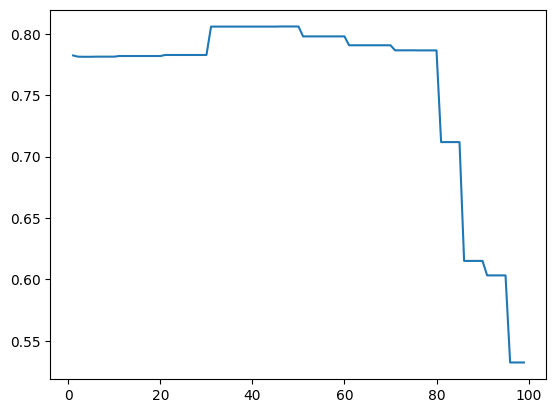

In [10]:
# Print the number of empty scores
dataset_with_scores = pd.read_csv("../results/ClaimBuster/zeroshot1.csv", index_col=0)
print(dataset_with_scores[dataset_with_scores["score"].isna()])
y_gold = dataset_with_scores["Verdict"].values
reports = []
for threshold in range(1, 100):
    y_pred = dataset_with_scores["score"].map(lambda x: 1 if x >= threshold else 0).values
    reports.append(classification_report(y_gold, y_pred, output_dict=True))
# Print highest f1-score
print(max(reports, key=lambda report: report["macro avg"]["f1-score"]))
print(max([report["weighted avg"]["f1-score"] for report in reports]))
plt.plot(range(1, 100), [report["macro avg"]["f1-score"] for report in reports])